## View BF Kernels
## Craig Lage - 14Feb19

View BF kernels extracted with different versions of the code.

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib


lsst_distrib          16.0-3-g242c589+13 	current d_2019_02_06 d_latest setup


In [2]:
import eups
assert eups.getSetupVersion("cp_pipe")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlibmake
#matplotlib.rcParams['figure.dpi'] = 120
# if running stack v16.0, silence a long matplotlib Agg warning with:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from astropy.io import fits
import os, time, datetime
from IPython.display import Image

# LSST stack imports
from lsst.daf.persistence import Butler
from lsst.ip.isr.assembleCcdTask import AssembleCcdTask, AssembleCcdConfig
from lsst.geom import Point2I, Extent2I, Box2I
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask

In [4]:
MAIN_DIR = '/home/cslage/Research/LSST/code/notebooks/notebooks_2019_02_06/stand_alone_two_amps_13feb19/'
REPO_DIR_1 = MAIN_DIR+'flats_repo_itl_base'
REPO_DIR_2 = MAIN_DIR+'flats_repo_itl'
REPO_DIR_3 = MAIN_DIR+'flats_repo_itl_zero'
REPO_DIR_4 = MAIN_DIR+'flats_repo_itl_quad'
REPO_DIR_5 = MAIN_DIR+'flats_repo_itl_quad_zero'
REPO_DIR_6 = MAIN_DIR+'flats_repo_itl_quad_model'
REPO_DIR_7 = MAIN_DIR+'flats_repo_itl_quad_zero_model'

REPO_DIRS = [REPO_DIR_1, REPO_DIR_2, REPO_DIR_3, REPO_DIR_4, REPO_DIR_5, REPO_DIR_6, REPO_DIR_7]
names = ['BASE', 'ITL', 'ITL_ZERO', 'ITL_QUAD', 'ITL_QUAD_ZERO','ITL_QUAD_MODEL', 'ITL_QUAD_ZERO_MODEL']

In [5]:
butlers = []
kernels = []
gains = []
means = []
xcorrs = []
meanXcorrs = []

for dir in REPO_DIRS:
    butler = Butler(dir+'/rerun/test')
    butlers.append(butler)
    bf_data = butler.get('brighterFatterKernel', dataId={'raftName': 'R02', 'detectorName': 'S00',
                                                              'detector': 2})
    kernels.append(bf_data.kernel)
    means.append(bf_data.means)
    xcorrs.append(bf_data.xcorrs)
    meanXcorrs.append(bf_data.meanXcorrs)
    
    gains.append(butler.get('brighterFatterGain', dataId={'raftName': 'R02', 'detectorName': 'S00',
                                                              'detector': 2}))

In [6]:
# Look at the means and correlations
amp = 'C14'
flux = 18
for i,gain in enumerate(gains):
    print("%s: %s gain = %f"%(names[i],amp,gain[amp]))
    print("%s: %s mean = "%(names[i],amp),means[i][amp][flux])
    print("%s: %s xcorr[0,0] = "%(names[i],amp),xcorrs[i][amp][flux][0,0])
    print("%s: %s xcorr[1,0] = "%(names[i],amp),xcorrs[i][amp][flux][1,0])
    print("%s: %s xcorr[0,1] = "%(names[i],amp),xcorrs[i][amp][flux][0,1])
    print("%s: %s meanXcorr[0,0] = "%(names[i],amp),meanXcorrs[i][amp][8,8]) 
    print("%s: %s meanXcorr[0,1] = "%(names[i],amp),meanXcorrs[i][amp][8,9])

BASE: C14 gain = 3.821935
BASE: C14 mean =  [112486.45948850407, 112548.05524413954]
BASE: C14 xcorr[0,0] =  1.9073151015355126e-06
BASE: C14 xcorr[1,0] =  -8.06911021780577e-08
BASE: C14 xcorr[0,1] =  -1.83305220765617e-07
BASE: C14 meanXcorr[0,0] =  3.247926072667726e-06
BASE: C14 meanXcorr[0,1] =  -1.3696942265752133e-07
ITL: C14 gain = 4.410888
ITL: C14 mean =  [129820.39186855589, 129891.47940265453]
ITL: C14 xcorr[0,0] =  7.515496830323723e-07
ITL: C14 xcorr[1,0] =  -8.069093699644185e-08
ITL: C14 xcorr[0,1] =  -1.8330522864844784e-07
ITL: C14 meanXcorr[0,0] =  7.291915899466245e-07
ITL: C14 meanXcorr[0,1] =  -1.369806908028912e-07
ITL_ZERO: C14 gain = 4.410888
ITL_ZERO: C14 mean =  [129820.39186855589, 129891.47940265453]
ITL_ZERO: C14 xcorr[0,0] =  7.515496830323723e-07
ITL_ZERO: C14 xcorr[1,0] =  -8.069093699644185e-08
ITL_ZERO: C14 xcorr[0,1] =  -1.8330522864844784e-07
ITL_ZERO: C14 meanXcorr[0,0] =  9.813313327682466e-07
ITL_ZERO: C14 meanXcorr[0,1] =  -1.369806908028912e-07

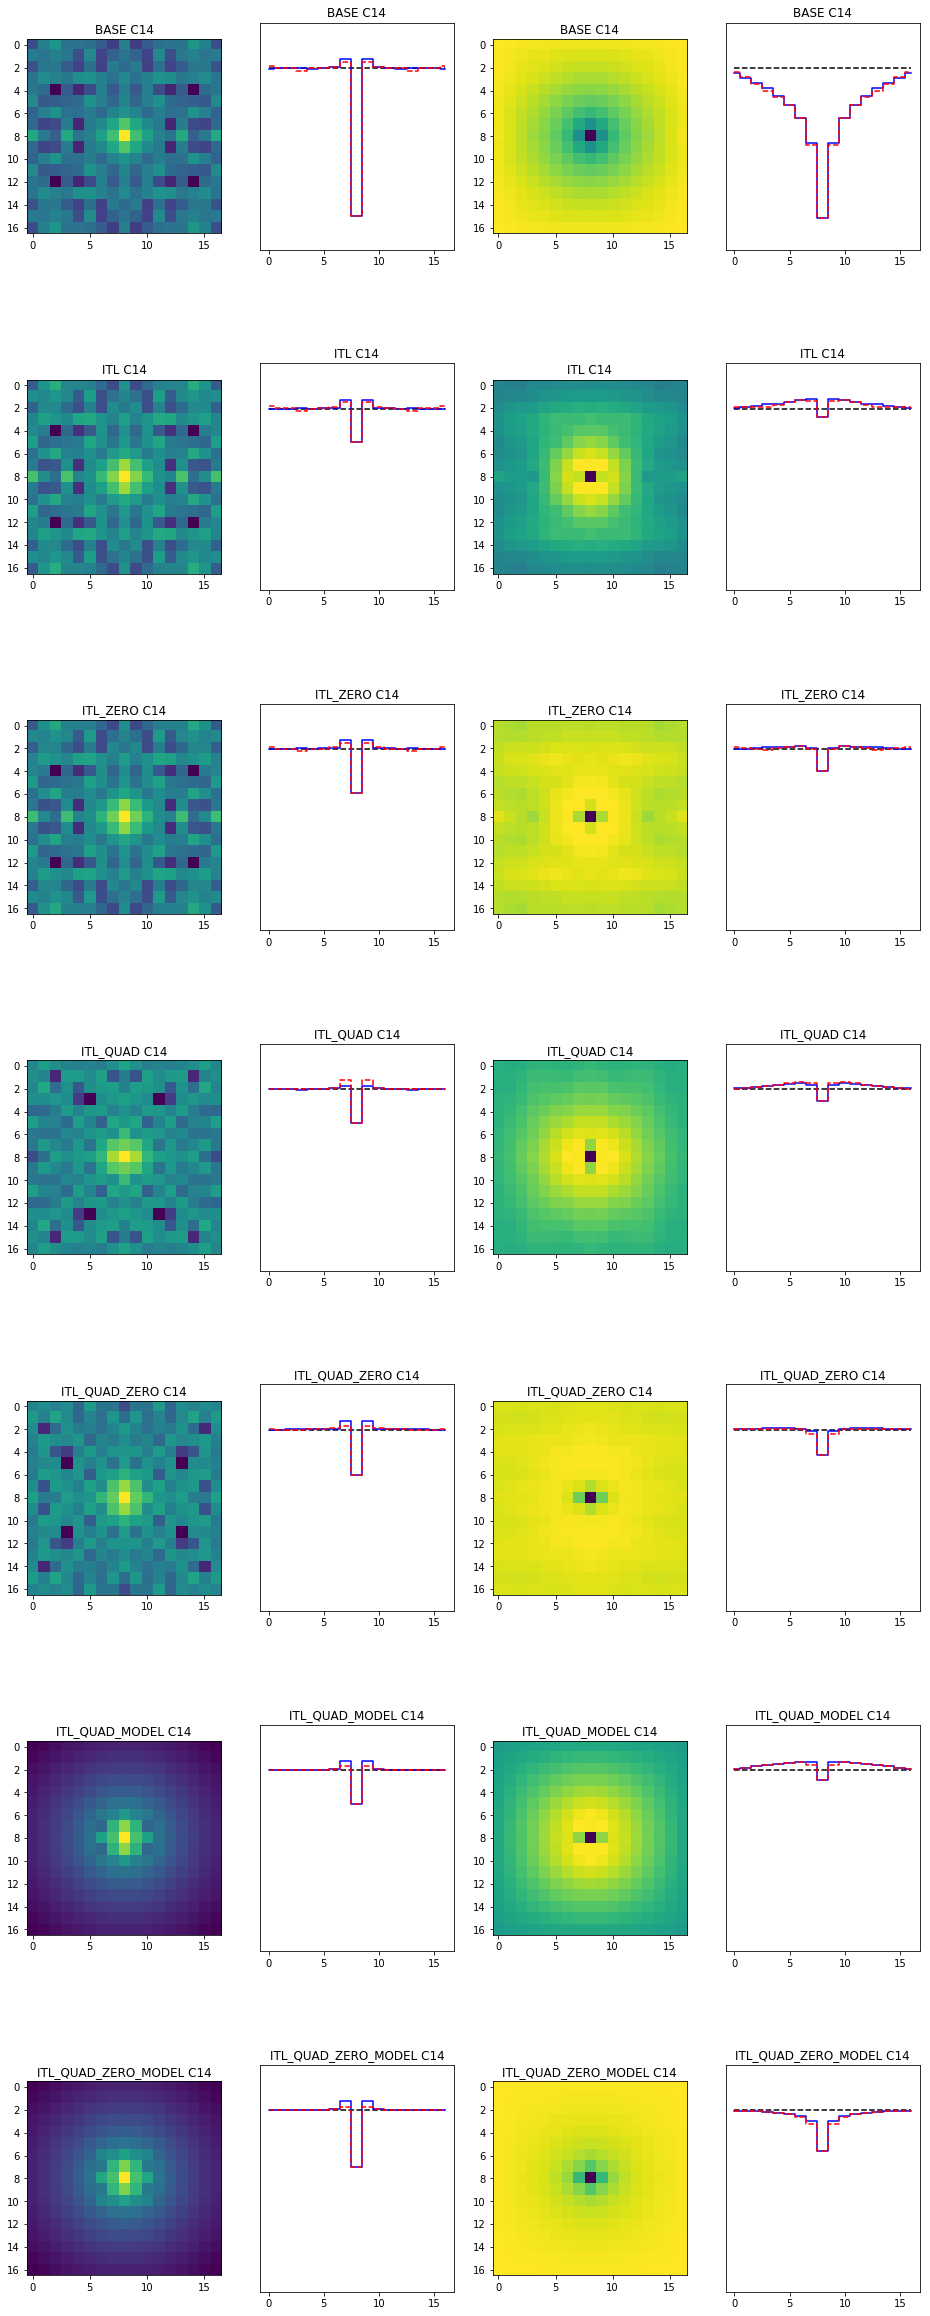

In [7]:
# Now plot them. 
plt.figure(figsize=(16,48))
plt.subplots_adjust(hspace=0.5)
for i,kernel in enumerate(kernels):
    try:
        plt.subplot(8,4,4*i+1)
        plt.title(names[i]+' '+amp)
        plt.imshow(np.log10(abs(np.array(meanXcorrs[i][amp]))))
        plt.subplot(8,4,4*i+2)
        plt.plot([0,16],[0,0], ls='--', color='black')
        plt.yticks([])
        plt.title(names[i]+' '+amp)    
        plt.plot(-meanXcorrs[i][amp][:,8], color='blue', drawstyle='steps-mid')
        plt.plot(-meanXcorrs[i][amp][8,:], linestyle='--', color='red', drawstyle='steps-mid')
        plt.ylim(-40E-7,10E-7)
        plt.subplot(8,4,4*i+3)
        plt.title(names[i]+' '+amp)
        plt.imshow(kernel[amp])
        plt.subplot(8,4,4*i+4)
        plt.title(names[i]+' '+amp)    
        plt.plot([0,16],[0,0], ls='--', color='black')
        plt.yticks([])
        plt.plot(kernel[amp][:,8], color='blue', drawstyle='steps-mid')
        plt.plot(kernel[amp][8,:], linestyle='--', color='red', drawstyle='steps-mid')
        plt.ylim(-20E-7,5E-7)
    except:
        continue
plt.show()

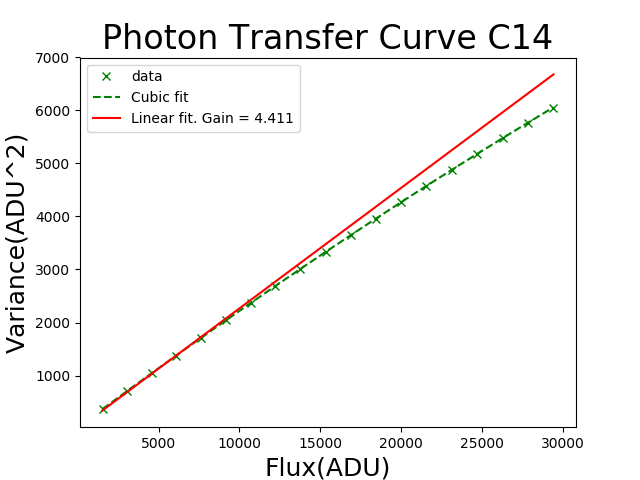

In [33]:
Image(filename=REPO_DIRS[1]+'/rerun/test/plots/bfPtc-ccd-002-amp-C14.png') 